 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [ ]:
# !pip install torchvision

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

Скачаем обучающую и контрольную выборки.

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
trainset.train_labels

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([9, 0, 0,  ..., 3, 0, 5])

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot|

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [ ]:
print(len(trainset))
print(len(testset))

60000
10000


Обучающая выборка имеет 60000 картинок, а в тестовой - 10000

Распределение классов в train

<BarContainer object of 10 artists>

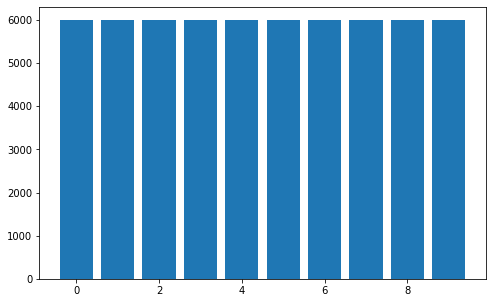

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(*trainset.train_labels.unique(return_counts=True))

Распределение классов в test

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


<BarContainer object of 10 artists>

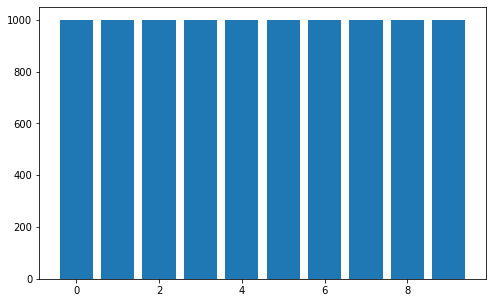

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(*testset.test_labels.unique(return_counts=True))

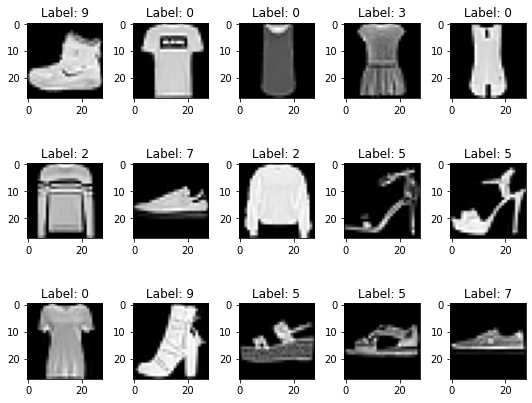

In [ ]:
# specify the number of rows and columns you want to see
num_row = 3
num_col = 5

# get a segment of the dataset
num = num_row*num_col
images = iter(trainset)

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    image, label = next(images)
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.squeeze(image.numpy()), cmap='gray')
    ax.set_title('Label: {}'.format(label))
plt.tight_layout()
plt.show()

In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

# MLP

In [ ]:
input_size = 784 #i.e 28*28*1
hidden_size = [256,128,64]
out_size = 10
learning_rate = 1e-3

In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with a 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.shape[0], -1)
        # Set the activation functions
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

model = MLPClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 30
train_losses, test_losses = [], []


for e in range(epochs):
    tot_train_loss = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tot_train_loss += loss.item()
    else:
        tot_test_loss = 0
        test_correct = 0
        # Turn off gradients for validation to save memory and speed up computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        model.train()

        # Get mean loss to enable comparison between train and test sets
        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss {:.3f}.. ".format(train_loss),
              "Test Loss {:.3f}.. ".format(test_loss),
              "Test Accuracy {:.3f}".format(test_correct / len(testloader.dataset)))

Epoch: 1/30..  Training Loss 0.149..  Test Loss 0.121..  Test Accuracy 0.825
Epoch: 2/30..  Training Loss 0.118..  Test Loss 0.105..  Test Accuracy 0.851
Epoch: 3/30..  Training Loss 0.113..  Test Loss 0.103..  Test Accuracy 0.853
Epoch: 4/30..  Training Loss 0.108..  Test Loss 0.100..  Test Accuracy 0.856
Epoch: 5/30..  Training Loss 0.106..  Test Loss 0.102..  Test Accuracy 0.853
Epoch: 6/30..  Training Loss 0.103..  Test Loss 0.101..  Test Accuracy 0.868
Epoch: 7/30..  Training Loss 0.103..  Test Loss 0.098..  Test Accuracy 0.860
Epoch: 8/30..  Training Loss 0.101..  Test Loss 0.103..  Test Accuracy 0.863
Epoch: 9/30..  Training Loss 0.099..  Test Loss 0.107..  Test Accuracy 0.858
Epoch: 10/30..  Training Loss 0.098..  Test Loss 0.100..  Test Accuracy 0.868
Epoch: 11/30..  Training Loss 0.099..  Test Loss 0.095..  Test Accuracy 0.872
Epoch: 12/30..  Training Loss 0.098..  Test Loss 0.104..  Test Accuracy 0.851
Epoch: 13/30..  Training Loss 0.096..  Test Loss 0.105..  Test Accuracy 0

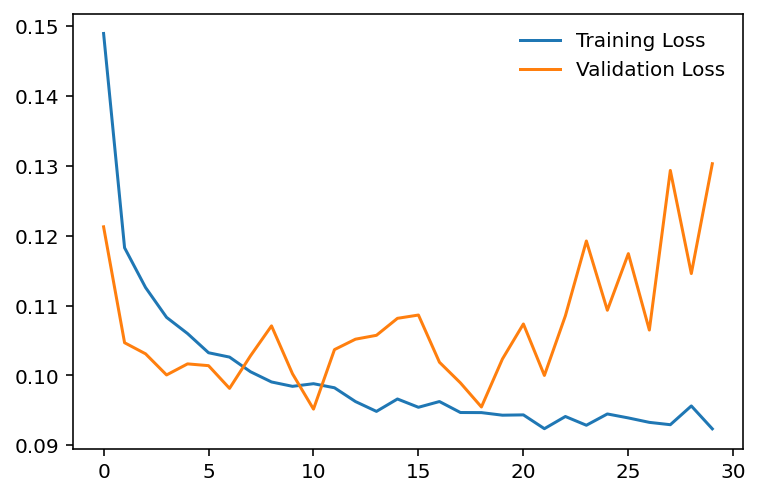

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=False)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 85 %
Accuracy for class: T-shirt/top is 85.7 %
Accuracy for class: Trouser is 96.0 %
Accuracy for class: Pullover is 75.4 %
Accuracy for class: Dress is 87.3 %
Accuracy for class: Coat  is 80.6 %
Accuracy for class: Sandal is 93.6 %
Accuracy for class: Shirt is 52.6 %
Accuracy for class: Sneaker is 96.8 %
Accuracy for class: Bag   is 94.3 %
Accuracy for class: Ankle boot is 93.1 %


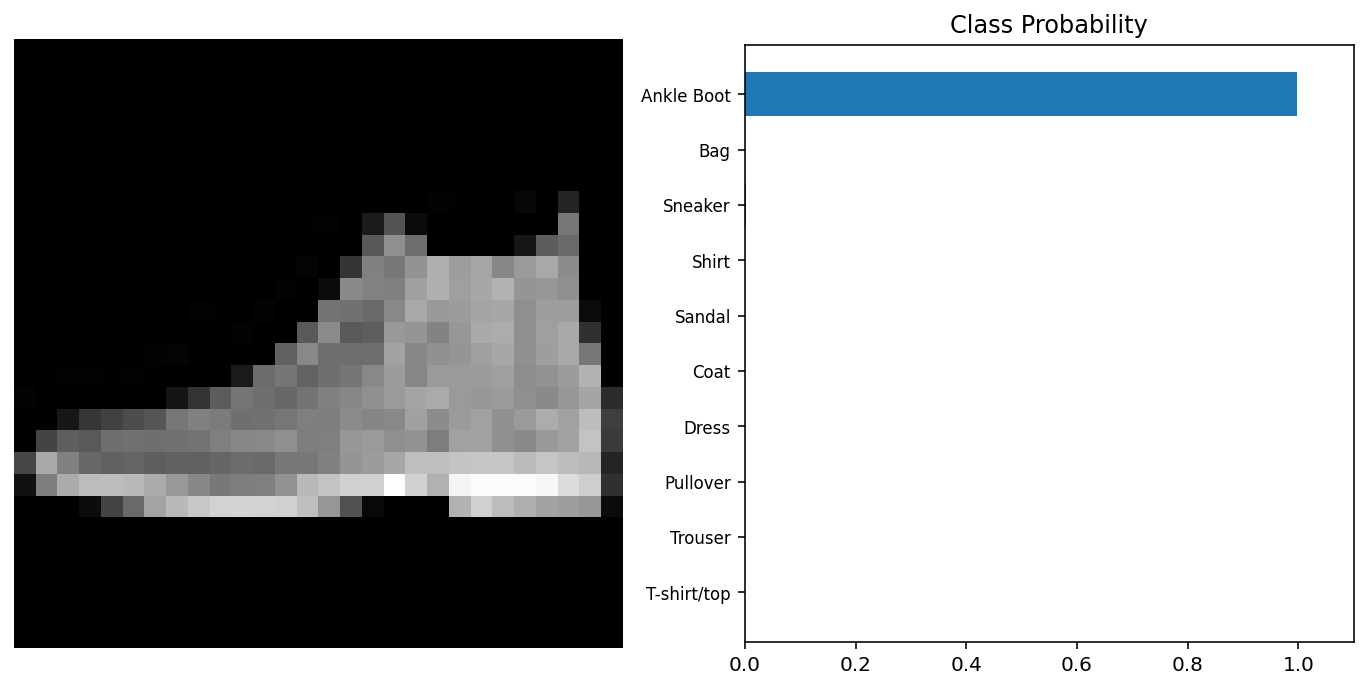

In [ ]:
model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
# Plot the image and probabilities through a custom function

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(12,15), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

view_classify(img.view(1, 28, 28), ps, version='Fashion')

# CNN

In [ ]:
import pandas as pd

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.datasets import fashion_mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
cnn_model = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

In [ ]:
cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

In [ ]:
cnn_model.fit(
    X_train, y_train, batch_size=64,
    epochs=30, verbose=1
)

Epoch 1/30
938/938 [==============================] - 30s 32ms/step - loss: 1.4605 - accuracy: 0.6441
Epoch 2/30
938/938 [==============================] - 29s 31ms/step - loss: 0.6654 - accuracy: 0.7720
Epoch 3/30
938/938 [==============================] - 29s 31ms/step - loss: 0.5095 - accuracy: 0.8190
Epoch 4/30
938/938 [==============================] - 30s 32ms/step - loss: 0.4393 - accuracy: 0.8381
Epoch 5/30
938/938 [==============================] - 29s 31ms/step - loss: 0.4035 - accuracy: 0.8467
Epoch 6/30
938/938 [==============================] - 29s 31ms/step - loss: 0.3588 - accuracy: 0.8702
Epoch 7/30
938/938 [==============================] - 29s 31ms/step - loss: 0.3196 - accuracy: 0.8853
Epoch 8/30
938/938 [==============================] - 29s 31ms/step - loss: 0.2987 - accuracy: 0.8933
Epoch 9/30
938/938 [==============================] - 30s 32ms/step - loss: 0.2838 - accuracy: 0.8980
Epoch 10/30
938/938 [==============================] - 29s 31ms/step - loss: 0.272

In [ ]:
score = cnn_model.evaluate(X_test, y_test, verbose=0)

print('test loss: {:.4f}'.format(score[0]))
print('test accuracy: {:.4f}'.format(score[1]))

test loss: 0.3491
test accuracy: 0.9007


 Таким образом, MLP выдала `accuracy` 0.873 на тестовой выборке, а CNN - 0.9007.